# Engineer the features
Esse notebook visa apresentar os passos tomados tanto para excluir features que sejam pouco ou irrelevantes para o propósito do modelo, quanto também adaptações nos dados que vez por outra se fazem necessárias para que se tenha o melhor resultado possível ao fim do processo.<br><br>

Caso o leitor queira fazer a feature engineering de maneira direta nos dados, existe uma função que encadeia toda a sequencia descrita aqui de maneira a realidar a engenharia das features.<br>

segue um exemplo da execução:<br>
```python
import sys

sys.path.insert(1, "../src/")
from features import feature

path = 'https://github.com/fdrigui/covid19_icu_admission_prediction/raw/main/data/raw/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
df = pd.read_excel(path)
df_limpo = clean(df)
df_featured = feature(df_limpo)
df_featured.head()
```

<a name="sumario"></a>
# Sumário
<!--ts-->
   * [Importe das Bibliotecas](#import)
   * [Leitura dos dados](#leitura)
   * [Escalar o AGE_PERCENTIL](#age)
   * [Drop WINDOW](#drop)
   * ['Quasi constant' features](#qqf)
   * [ROC AUC Univariável](#rocauc)
<!--te-->

<a name="import"></a>
# Importe das Bibliotecas

## Bibliotecas Externas

In [1]:
import pandas as pd
import numpy as np

#from sklearn.feature_selection import VarianceThreshold
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import roc_auc_score

#from sklearn.ensemble import RandomForestClassifier

## Bibliotecas Internas

In [2]:
import sys
sys.path.insert(1, "../src/")
from features import scale_age_percentil
from features import drop_low_variance_feature, plot_low_variance_feature
from features import plot_univariate_roc_auc, drop_univariate_roc_auc
from features import high_correlation_feature

-----------------
Retornar ao [Sumário](#sumario)

<a name="leitura"></a>
# Leitura dos dados
Faz a leitura dos dados que serão usados para a a etapa de *feature Engineering*.<br>
**```df: pd.DataFrame```** é o DataFrame que receberá os valores limpos do caminho: ```../data/interim/df7_cleaned.csv```.

In [3]:
# Leitura do raw data desse  projeto no Github
df = pd.read_csv('../data/interim/df_7_cleaned.csv', index_col='PATIENT_VISIT_IDENTIFIER')

# Imprime na tela todas as colunas em vez de as 10 primeiras e 10 ultimas
pd.set_option('max_columns', df.shape[1])
df.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN,BE_ARTERIAL,BE_VENOUS,BIC_ARTERIAL,BIC_VENOUS,BILLIRUBIN,BLAST,CALCIUM,CREATININ,FFA,GGT,GLUCOSE,HEMATOCRITE,HEMOGLOBIN,INR,LACTATE,LEUKOCYTES,LINFOCITOS,NEUTROPHILES,P02_ARTERIAL,P02_VENOUS,PC02_ARTERIAL,PC02_VENOUS,PCR,PH_ARTERIAL,PH_VENOUS,PLATELETS,POTASSIUM,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.000000,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.

In [4]:
print(f'O Dataframe df possui {df.shape[1]} features, {df.shape[0]} observações e 1 saída "ICU"')

O Dataframe df possui 86 features, 351 observações e 1 saída "ICU"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 384
Data columns (total 86 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_ABOVE65                       351 non-null    int64  
 1   AGE_PERCENTIL                     351 non-null    object 
 2   GENDER                            351 non-null    int64  
 3   DISEASE GROUPING 1                351 non-null    float64
 4   DISEASE GROUPING 2                351 non-null    float64
 5   DISEASE GROUPING 3                351 non-null    float64
 6   DISEASE GROUPING 4                351 non-null    float64
 7   DISEASE GROUPING 5                351 non-null    float64
 8   DISEASE GROUPING 6                351 non-null    float64
 9   HTN                               351 non-null    float64
 10  IMMUNOCOMPROMISED                 351 non-null    float64
 11  OTHER                             351 non-null    float64
 12  ALBUMIN 

<a name="age"></a>
# Escalar o AGE_PERCENTIL
A *feature* chamada ```AGE_PERCENTIL``` é uma *feature* categórica. A categoria funciona da seguinte maneira:<br>
Inicialmente os dados são ordenados por idade, do mais novo para o mais velho, e em seguida separados nos percentis, ex:
10th é a categoria que representa os 10% de pacientes com a menor idade, já o 20th representa o intervalo de pacientes que estão entre os 10% e 20% da idade e assim por diante ([veja aqui](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/276074)).<br>
Como alguns modelos não trabalham com dados categóricos, seria interessante, caso possível, transformar esse dado categórico em um valor real entre ma determinada faixa.<br>
Como alguns modelos consideram a magnitude dos valores como peso para a feature, ou seja, se todas as features vão de 0 - 1 por exemplo e uma única vai de 0 - 100, poderia ser atribuido um peso maior para essa feature, que na prática, poderia nem contribuir tanto com o resultado. Para evitar esse tipo de erro, a feature categórica ```AGE_PERCENTIL``` vai ser convertida para numérica e escalada para um valor entre 0 e 1.<br>

**```df_1_agescaled: pd.DataFrame```** vai receber a resposta da função ```scale_age_percentil()``` com os dados normalizados entre os valores 0 -  1. 

In [6]:
df['AGE_PERCENTIL'].value_counts()

20th          42
30th          39
40th          38
10th          36
80th          36
70th          34
50th          34
Above 90th    34
60th          30
90th          28
Name: AGE_PERCENTIL, dtype: int64

<AxesSubplot:>

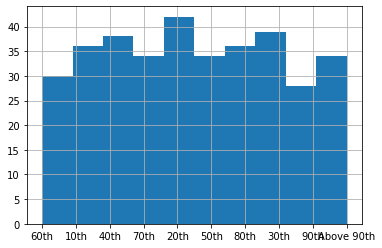

In [7]:
df['AGE_PERCENTIL'].hist()

In [8]:
df_1_agescaled = scale_age_percentil(df)

In [9]:
df_1_agescaled['AGE_SCALED'].value_counts()

0.111111    42
0.222222    39
0.333333    38
0.000000    36
0.777778    36
0.666667    34
0.444444    34
1.000000    34
0.555556    30
0.888889    28
Name: AGE_SCALED, dtype: int64

<AxesSubplot:>

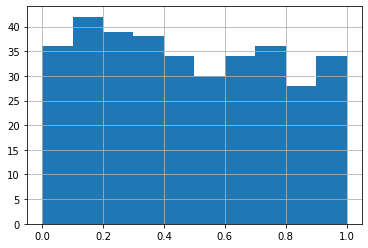

In [10]:
df_1_agescaled['AGE_SCALED'].hist()

-----------------
Retornar ao [Sumário](#sumario)

<a name="drop"></a>
# Drop WINDOW feature
A *feature* chamada ```'WINDOW'``` também não tem nenhuma relevancia para o modelo, uma vez que ela contem o mesmo valor em todas as observações.<br>
Ao fim da etapa de **Limpeza** foi selecionado somente a primeira janela de tempo, ou seja, somente valores ```'0-2'```. Por isso a *feature* será removida do DataFrame.<br>
**```df_2_wo_window: pd.DataFrame```** vai receber o valor de ```df_1_agescaled```sem o ```'WINDOW'```.<br>

In [11]:
df_1_agescaled['WINDOW'].unique()

array(['0-2'], dtype=object)

In [12]:
df_2_wo_window = df_1_agescaled.drop('WINDOW', axis=1)

-----------------
Retornar ao [Sumário](#sumario)

<a name="qqf"></a>
# Remove 'quasi constant features'
*Features* que tem baixa variação (se tornando quase constantes) difícilmente servem para predizer alguma condição. Por isso, a idéia aqui é usar o ```sklean.VarianceThreshold``` para identificar quais variaveis tem esse tipo de comportamento para que possam ser removidas.
A função ```plot_low_variance_feature``` e a ```drop_low_variance_feature``` mostra e remove as features que tem variação abaixo do threshold.<br>
**```df_3_wo_low_var_feat: pd.DataFrame```** vai receber o DataFrame após passar pela função ```drop_low_variance_feature```, ou seja, sem *feature* com baixas variações.<br>


In [13]:
plot_low_variance_feature(df_2_wo_window, threshold=0.05)

Index(['DISEASE GROUPING 2', 'DISEASE GROUPING 4', 'DISEASE GROUPING 6',
       'ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS',
       'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE',
       'HEMATOCRITE', 'INR', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES',
       'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS',
       'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL',
       'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER',
       'RESPIRATORY_RATE_MEAN', 'OXYGEN_SATURATION_MEAN',
       'OXYGEN_SATURATION_MEDIAN', 'TEMPERATURE_MIN', 'OXYGEN_SATURATION_MIN',
       'BLOODPRESSURE_DIASTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MAX',
       'HEART_RATE_MAX', 'RESPIRATORY_RATE_MAX', 'OXYGEN_SATURATION_MAX',
       'BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF',
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
      

In [14]:
df_3_wo_low_var_feat = drop_low_variance_feature(df_2_wo_window)
    
plot_low_variance_feature(df_3_wo_low_var_feat)

Index([], dtype='object')


<a name="rocauc"></a>
# ROC AUC Univariável
Existem *features* que apesar de terem uma variação relevante, não conseguem discretzar bem as categorias de saída.<br>
Vamos usar a métrica ROC AUC, para avaliar a força da feature de discriminar a saída ```ICU``` entre as classes **0** e **1**.<br>
Vale lembrar que um ROC AUC = 0.5 indica que a *feature* não tem influencia na classificação, e a medida que os valores se aproximam de 1 ou de 0, indica que a força que a feature tem de separar as classes de saída aumentam também.

In [15]:
df_4_wo_low_roc_auc = drop_univariate_roc_auc(df_3_wo_low_var_feat, low_cutband=0.48, high_cutband=0.52, random_state=791723, plot=False)

--------------------
Foram encontradas 18 features com ROC AOC entre 0.48 e 0.52


-----------------
Retornar ao [Sumário](#sumario)

# Feature de alta correlação

[1] LEUKOCYTES x [3] NEUTROPHILES; corr: 0.96
[9] BLOODPRESSURE_DIASTOLIC_MEAN x [12] BLOODPRESSURE_DIASTOLIC_MEDIAN; corr: 0.99
[9] BLOODPRESSURE_DIASTOLIC_MEAN x [17] BLOODPRESSURE_DIASTOLIC_MIN; corr: 0.96
[10] RESPIRATORY_RATE_MEAN x [14] RESPIRATORY_RATE_MEDIAN; corr: 0.99
[10] RESPIRATORY_RATE_MEAN x [25] RESPIRATORY_RATE_MAX; corr: 0.97
[11] TEMPERATURE_MEAN x [15] TEMPERATURE_MEDIAN; corr: 0.99
[11] TEMPERATURE_MEAN x [21] TEMPERATURE_MIN; corr: 0.97
[11] TEMPERATURE_MEAN x [26] TEMPERATURE_MAX; corr: 0.97
[12] BLOODPRESSURE_DIASTOLIC_MEDIAN x [17] BLOODPRESSURE_DIASTOLIC_MIN; corr: 0.96
[13] BLOODPRESSURE_SISTOLIC_MEDIAN x [18] BLOODPRESSURE_SISTOLIC_MIN; corr: 0.96
[13] BLOODPRESSURE_SISTOLIC_MEDIAN x [23] BLOODPRESSURE_SISTOLIC_MAX; corr: 0.97
[14] RESPIRATORY_RATE_MEDIAN x [25] RESPIRATORY_RATE_MAX; corr: 0.96
[15] TEMPERATURE_MEDIAN x [21] TEMPERATURE_MIN; corr: 0.96
[15] TEMPERATURE_MEDIAN x [26] TEMPERATURE_MAX; corr: 0.95


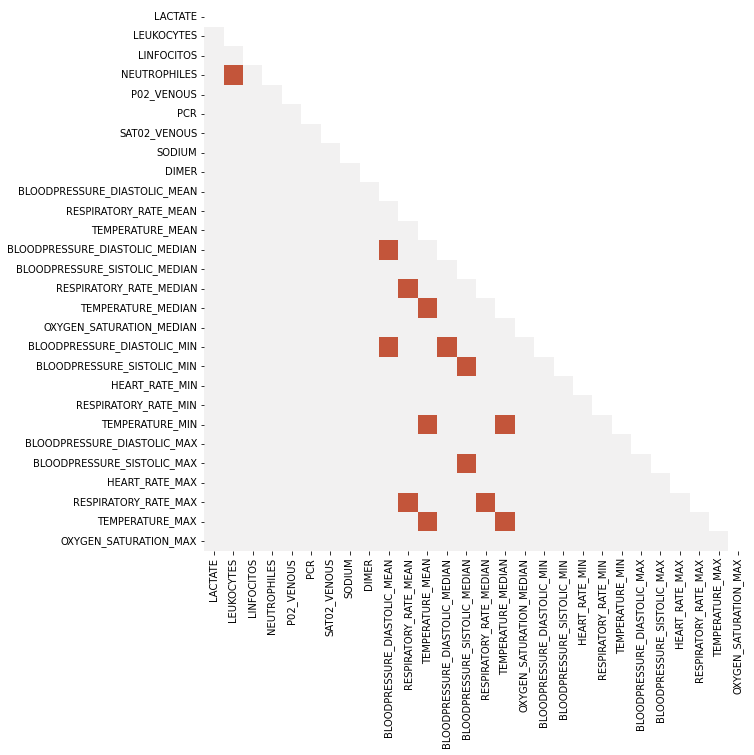

In [16]:
high_correlation_feature(df_4_wo_low_roc_auc)

-----------------
Retornar ao [Sumário](#sumario)

<a name="clean"></a>
# Salva dados 

O DataFrame: ```df_7_cleaned``` será salvo como csv na pasta ```../data/interim/```. Isso porque os dados podem ainda sofrer alterações na etapa de análise das *features*.

In [ ]:
df_2_featured.to_csv('../data/interim/df_featured.csv')

-----------------
Retornar ao [Sumário](#sumario)

In [ ]:
# Compute the correlation matrix
corr = df_1_agescaled.iloc[:,12:-2].corr().abs()
masked_corr = corr
masked_corr[corr <= 0.95] = 0
masked_corr[corr > 0.95] = 1

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(masked_corr, mask=mask, cmap=cmap, center=0, square=True, vmin=0, vmax=1.0, cbar=False)

In [ ]:
upper_tri = masked_corr.where(np.triu(np.ones(masked_corr.shape),k=1).astype(np.bool))
correlated = []
for i in range(72):
    for j in range(72):
        if upper_tri.iloc[i,j] > 0.95:
            print(f'{upper_tri.index[i]} x {upper_tri.columns[j]}')
            correlated.append([upper_tri.index[i], upper_tri.columns[j]])

# Conclusão

# Referência

* https://en.wikipedia.org/wiki/Feature_engineering
* https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
* https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
* https://towardsdatascience.com/what-is-feature-engineering-bfd25b2b26b2
* https://searchdatamanagement.techtarget.com/feature/Key-steps-in-the-feature-engineering-process
* https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f
* https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
* https://www.youtube.com/watch?v=JEfBvK91CXc&t=329s
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html